# Weather in Tromsø over time

## Hypothesis

In this project we will look at the historical weather data gathered in Tromsø and see if the winters and summers have changed in the last years compared to earlier trends. We will look at snow-depth, temperature, precipitation and other factors if there has been a changing trend and if one can see the effects of climate change in Tromsø. 

## Requirements

In [59]:
import pandas as pd 
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import altair as alt 
import reading_data as rd



In [110]:
#Midlertidig løsning for å oppdatere reading_data
import importlib
importlib.reload(rd)


<module 'reading_data' from '/Users/tha222/git-folder/troms_weather/scripts/reading_data.py'>

In [111]:
client_id = '../ignore_me/client_id.txt'
client_secret = '../ignore_me/client_secret.txt'


## Finding the weather stations of Tromsø

Where ate the stations we have? And how old are they? 

In [117]:
station_id = pd.DataFrame(rd.FindingStations(client_id, client_secret
                                             ).get_sensors(69.95, 18.95, 30, "TROMSØ"),
                                             columns=['station_id', 'name'])

start_date, coor, names = [], [], []
for station in station_id['station_id']:
    location = rd.ReadingData(station, client_id, client_secret)
    start, end, coordinates, name = location.get_station_info()
    start_date.append(start)
    coor.append(coordinates)
    names.append(name)


In [118]:
station_id['date'] = start_date
station_id['year'] = pd.to_datetime(station_id['date']).dt.strftime('%Y')
station_id['lon'] = [cor[0] for cor in coor]
station_id['lat'] = [cor[1] for cor in coor]
station_id['name'] = names
station_id.sort_values(by='date', inplace=True)


In [163]:
station_coordinates = gpd.GeoDataFrame(station_id, 
                                       geometry=gpd.points_from_xy(
                                           station_id.lon, station_id.lat))
station_coordinates.crs = 'EPSG:4326'
test = station_coordinates.head(20)


In [164]:
station_id.reset_index(drop=True, inplace=True)
station_id


,station_id,name,date,year,lon,lat
0,SN90450,Tromsø (Vervarslinga),1895-08-01,1895,18.93680,69.65370
1,SN90490,Tromsø LH,1964-09-30,1964,18.91330,69.67670
2,SN90400,Tromsø (Holt),1987-05-04,1987,18.90950,69.65380
3,SN90491,Stor-Kjølen,1998-04-02,1998,18.78750,69.73330
4,SN90720,Måsvik,2003-10-08,2003,18.69380,69.99030
5,SN91020,Breivikeidet,2003-12-05,2003,19.51030,69.63670
6,SN90980,Oldervik,2003-12-05,2003,19.66470,69.75650
7,SN90721,Gråhaugen,2005-08-04,2005,18.70530,69.99970
8,SN90495,Stakkevollan,2011-10-20,2011,18.98200,69.69420
9,SN90451,Tromsø PLU,2011-10-20,2011,18.93650,69.65370


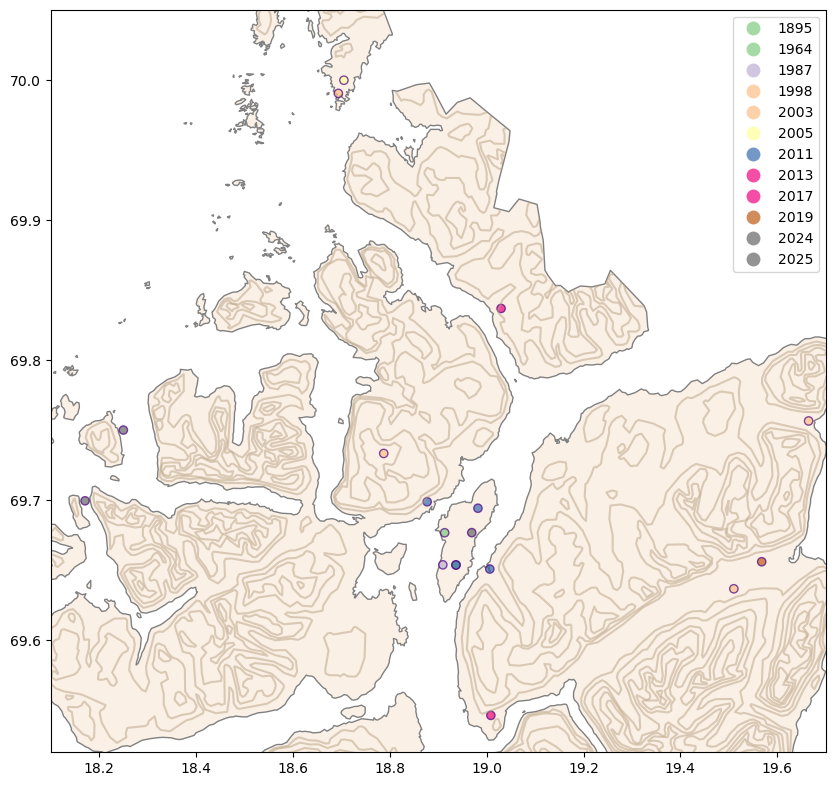

In [207]:
gdf = gpd.read_file('../data/Kommuner-L.geojson')
hoyde = gpd.read_file('../data/Basisdata_55_Troms_25833_N1000Hoyde_GML.gml', 
                      layer='Høydekurve')
hoyde = hoyde.to_crs(gdf.crs)
tromso = gdf[gdf['name'] == 'Tromsø']
clipped_hoyde = gpd.clip(hoyde, tromso)
fig, ax = plt.subplots(figsize=(10, 10))
tromso.plot(ax=ax, color="linen", edgecolor="grey")
clipped_hoyde.plot(ax=ax, color="xkcd:taupe", markersize=0.1, alpha=0.5)
test.plot(ax=ax, column='year', cmap='Accent', marker='o', legend=True, 
          alpha=0.7, edgecolor='indigo')
ax.set_xlim(18.1,19.7)
ax.set_ylim(69.52,70.05)
plt.show()


## Temperature over the years

How has temperature changed over time? 
- Average temperature for each season 
- Extreme temperature now and then 
- Daily temperature range over time for summer and winter 
- Local differences in temperature 


### MIDLERTIDIG START

Fokuserer på disse stasjonene:
- Kjølen
- Måsvik
- Værvarslinka
- Tromsø LH
- Oldervik 
  
for en blanding av fjell, by, mot hav og fjord

### MIDLERTIDIG OVER

In [ ]:
chosen_stations = station_id.iloc[[0, 1, 3, 4, 6]]
chosen_stations


,station_id,name,date,year,lon,lat
0,SN90450,Tromsø (Vervarslinga),1895-08-01,1895,18.9368,69.6537
1,SN90490,Tromsø LH,1964-09-30,1964,18.9133,69.6767
3,SN90491,Stor-Kjølen,1998-04-02,1998,18.7875,69.7333
4,SN90720,Måsvik,2003-10-08,2003,18.6938,69.9903
6,SN90980,Oldervik,2003-12-05,2003,19.6647,69.7565
